In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cmcrameri import cm
from pqcd.utils import (
    rcparams, 
    to_GeV_per_cubic_femtometre
    )
plt.rcParams.update(rcparams)

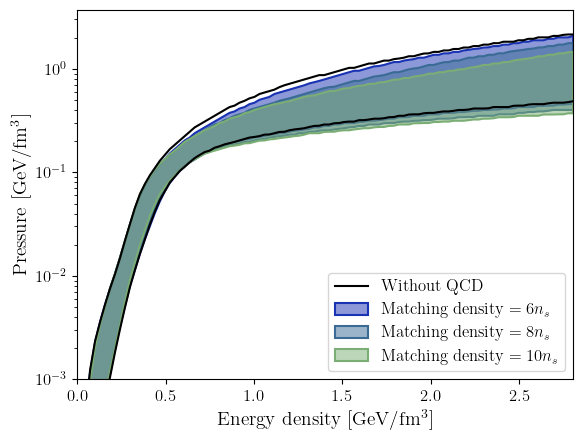

In [2]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
ax.plot(x, quantiles.loc[95,:].values, color='k')

ns_list = [6,8,10]
linestyles = ['-', '-', '-']

for i, ns in enumerate(ns_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_Xmarg.csv')
    )

    ax.fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=list(cm.imola(i/(len(ns_list))))[:3]+[0.5], 
        edgecolor=cm.imola(i/(len(ns_list))),
        linewidth=1.5,
        linestyle=linestyles[i],
        label=f'Matching density $={ns}n_s$'
        )
    
    # ax.fill_between(
    #     x, 
    #     quantiles.loc[5,:].values, 
    #     quantiles.loc[95,:].values, 
    #     color=list(cm.imola(i/(len(ns_list))))[:3]+[0.0], 
    #     edgecolor=cm.imola(i/(len(ns_list))),
    #     linewidth=1.5,
    #     zorder=2
    #     )

ax.legend(loc='lower right')

ax.set_ylim(1e-3)
ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]')

fig.savefig(
    'figures/pressure_vs_energy_density/pressure_vs_energy_density_Xmarg.pdf', 
    bbox_inches='tight'
    )

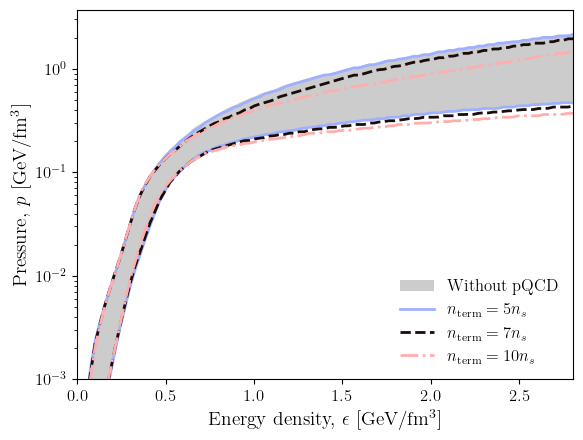

In [3]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

# ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
# ax.plot(x, quantiles.loc[95,:].values, color='k')

ax.fill_between(
    x, 
    quantiles.loc[5,:].values, 
    quantiles.loc[95,:].values, 
    color='k', 
    linewidth=0,
    label='Without pQCD',
    alpha=0.2
    )

ns_list = [5,7,10]
linestyles = ['-', '--', '-.', ':']

for i, ns in enumerate(ns_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_Xmarg.csv')
    )

    ax.plot(
        x,
        quantiles.loc[5,:].values,
        color=cm.berlin(i/(len(ns_list)-1)),
        linestyle=linestyles[i],
        linewidth=2,
        label=f'$n_\mathrm{{term}}={ns}n_s$'
        )
    ax.plot(
        x,
        quantiles.loc[95,:].values,
        color=cm.berlin(i/(len(ns_list)-1)),
        linestyle=linestyles[i],
        linewidth=2
    )

    # ax.fill_between(
    #     x, 
    #     quantiles.loc[5,:].values, 
    #     quantiles.loc[95,:].values, 
    #     color=list(cm.berlin(i/(len(ns_list)-1)))[:3]+[0.], 
    #     edgecolor=cm.berlin(i/(len(ns_list)-1)),
    #     linewidth=2,
    #     linestyle=linestyles[i],
    #     label=f'Matching density $={ns}n_s$'
    #     )
    
    # ax.fill_between(
    #     x, 
    #     quantiles.loc[5,:].values, 
    #     quantiles.loc[95,:].values, 
    #     color=list(cm.imola(i/(len(ns_list))))[:3]+[0.0], 
    #     edgecolor=cm.imola(i/(len(ns_list))),
    #     linewidth=1.5,
    #     zorder=2
    #     )

ax.legend(loc='lower right', frameon=False)

ax.set_ylim(1e-3)
ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

fig.savefig('figures/presentation/pressure_vs_energy_density_Xmarg.png', bbox_inches='tight', dpi=300)

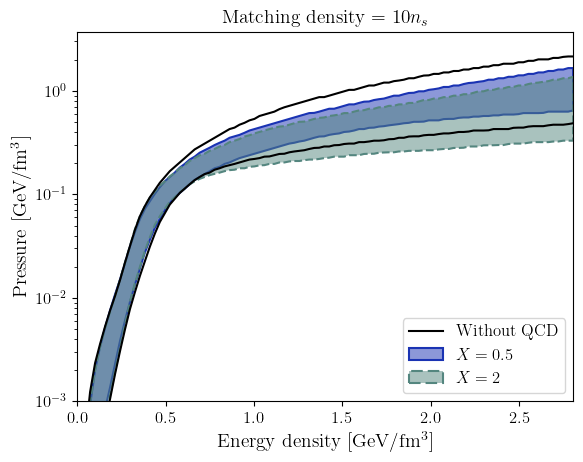

In [4]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
ax.plot(x, quantiles.loc[95,:].values, color='k')

ns = 10
X_list = [0.5, 2]

for i, X in enumerate(X_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_X{X}.csv')
    )

    ax.fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=list(cm.imola(i/(len(X_list))))[:3]+[0.5], 
        edgecolor=cm.imola(i/(len(X_list))),
        linewidth=1.5,
        linestyle=linestyles[i],
        label=f'$X={X}$'
        )

ax.legend(loc='lower right')

ax.set_ylim(1e-3)
ax.set_xlim(0., x[-1])

ax.set_title(f'Matching density $={ns:02}n_s$')
ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]')

fig.savefig(f'figures/pressure_vs_energy_density/pressure_vs_energy_density_{ns:02}nsat_Xcomparison.pdf', bbox_inches='tight')

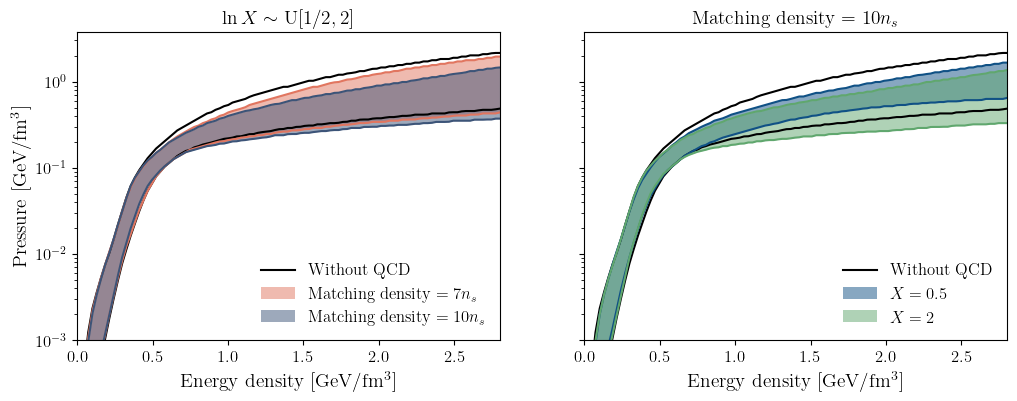

In [5]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
axs[0].set_yscale('log')

x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

for ax in axs:
    ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
    ax.plot(x, quantiles.loc[95,:].values, color='k')

axs[0].set_title('$\ln{X} \sim \mathrm{U}[1/2,2]$')

ns_list = [7,10]
c_list = [cm.lipari(0.65), cm.lipari(0.2)]

for i, ns in enumerate(ns_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_Xmarg.csv')
    )

    axs[0].fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=c_list[i], 
        alpha=0.5,
        linewidth=0,
        label=f'Matching density $={ns}n_s$'
        )
    
    axs[0].plot(
        x, 
        quantiles.loc[5,:].values,
        color=c_list[i],
        zorder=2
        )
    
    axs[0].plot(
        x, 
        quantiles.loc[95,:].values,
        color=c_list[i],
        zorder=2
        )


ns = 10
axs[1].set_title(f'Matching density $={ns:02}n_s$')

X_list = [0.5, 2]
c_list = [cm.navia(0.2), cm.navia(0.65)]

for i, X in enumerate(X_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_X{X}.csv')
    )

    axs[1].fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=c_list[i], 
        alpha=0.5,
        linewidth=0,
        label=f'$X={X}$'
        )
    
    axs[1].plot(
        x, 
        quantiles.loc[5,:].values,
        color=c_list[i],
        zorder=2
        )
    
    axs[1].plot(
        x, 
        quantiles.loc[95,:].values,
        color=c_list[i],
        zorder=2
        )

axs[0].legend(loc='lower right', frameon=False)
axs[1].legend(loc='lower right', frameon=False)

axs[0].set_ylim(1e-3)
axs[0].set_xlim(0., x[-1])

axs[0].set_xlabel('Energy density [GeV/fm$^3$]')
axs[1].set_xlabel('Energy density [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure [GeV/fm$^3$]')

fig.savefig(
    'figures/pressure_vs_energy_density/pressure_vs_energy_density.pdf', 
    bbox_inches='tight'
    )


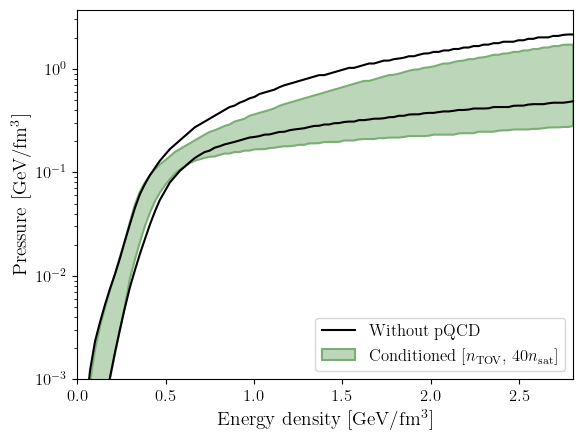

In [3]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without pQCD')
ax.plot(x, quantiles.loc[95,:].values, color='k')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_ntov_marg.csv')
)

ax.fill_between(
    x, 
    quantiles.loc[5,:].values, 
    quantiles.loc[95,:].values, 
    color=list(cm.imola(i/(len(ns_list))))[:3]+[0.5], 
    edgecolor=cm.imola(i/(len(ns_list))),
    linewidth=1.5,
    linestyle=linestyles[i],
    label='Conditioned [$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]',
    )

ax.legend(loc='lower right')

ax.set_ylim(1e-3)
ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]')

fig.savefig(
    'figures/pressure_vs_energy_density/pressure_vs_energy_density_ntov_marg.pdf', 
    bbox_inches='tight'
    )

Text(0, 0.5, 'Pressure [GeV/fm$^3$]')

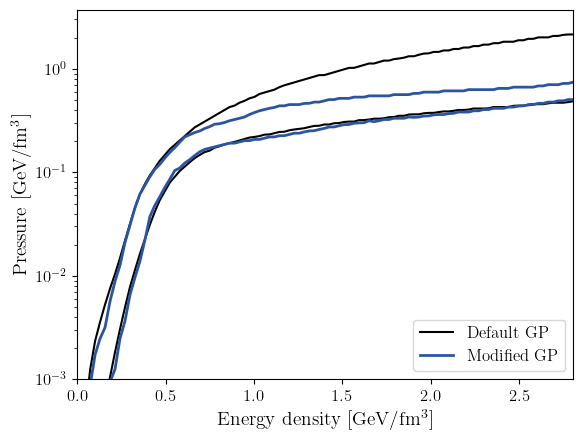

In [2]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

# Draws from the "default" GP with astro constraints only

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Default GP')
ax.plot(x, quantiles.loc[95,:].values, color='k')

ylim = ax.get_ylim()

# Draws from the modified GP with radio and x-ray constraints

set_number = 12
N = 1863

collated_eos = pd.read_csv(
    f'../data/eos-draws-modified-{set_number:02}.csv', index_col=0
)

# for n, data in collated_eos.iterrows():

#     eos = pd.read_csv(
#         f'../data/eos-draws-modified/{set_number:02}/margagn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
#         )

#     pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
#     energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)

#     if data['logweight_total'] > -np.inf:
#         c = cm.imola(0.7)
#         zorder=0.2
#     else:
#         c = 'C3'
#         zorder=0.1

#     ax.plot(energy_density, pressure, color=c, alpha=0.1, zorder=zorder)

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-modified/12/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color=cm.imola(0.2), linewidth=2, label='Modified GP')
ax.plot(x, quantiles.loc[95,:].values, color=cm.imola(0.2), linewidth=2)

# ax.fill_between(
#     x, 
#     quantiles.loc[5,:].values, 
#     quantiles.loc[95,:].values, 
#     color=list(cm.imola(i/(len(ns_list))))[:3]+[0.5], 
#     edgecolor=cm.imola(i/(len(ns_list))),
#     linewidth=1.5,
#     linestyle=linestyles[i],
#     label='Conditioned [$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]',
#     )

ax.legend(loc='lower right')

ax.set_ylim(1e-3, ylim[1])
ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]')

# fig.savefig(
#     'figures/pressure_vs_energy_density/pressure_vs_energy_density_ntov_marg.pdf', 
#     bbox_inches='tight'
#     )